本次实战我们构建一个深度神经网络，并用它来完成和《第一个人工智能程序》时同样的任务——识别图片中是否有猫。在《第一个人工智能程序》时，我们使用的是单神经元神经网络，本次我们使用深度神经网络来提升预测精准度。

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# 加载我们自定义的工具函数
from testCases import *
from dnn_utils import *

# 设置一些画图相关的参数
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

ModuleNotFoundError: ignored

首先，我们将构建深度神经网络所需的工具函数一个个给编写好。

In [ ]:
# 该函数用于初始化所有层的参数w和b
def initialize_parameters_deep(layer_dims):
    """
    参数:
    layer_dims -- 这个list列表里面，包含了每层的神经元个数。
    例如，layer_dims=[5,4,3]，表示第一层有5个神经元，第二层有4个，最后一层有3个神经元
    
    返回值:
    parameters -- 这个字典里面包含了每层对应的已经初始化了的W和b。
    例如，parameters['W1']装载了第一层的w，parameters['b1']装载了第一层的b
    """
#     np.random.seed(1)
    parameters = {}
    L = len(layer_dims) # 获取神经网络总共有几层

    # 遍历每一层，为每一层的W和b进行初始化
    for l in range(1, L):
        # 构建并随机初始化该层的W。由我前面的文章《1.4.3 核对矩阵的维度》可知，Wl的维度是(n[l] , n[l-1]) 
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l-1])
        # 构建并初始化b
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        # 核对一下W和b的维度是我们预期的维度
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    #就是利用上面的循环，我们就可以为任意层数的神经网络进行参数初始化，只要我们提供每一层的神经元个数就可以了。       
    return parameters

In [ ]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.72642933 -0.27358579 -0.23620559 -0.47984616  0.38702206]
 [-1.0292794   0.78030354 -0.34042208  0.14267862 -0.11152182]
 [ 0.65387455 -0.92132293 -0.14418936 -0.17175433  0.50703711]
 [-0.49188633 -0.07711224 -0.39259022  0.01887856  0.26064289]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.55030959  0.57236185  0.45079536  0.25124717]
 [ 0.45042797 -0.34186393 -0.06144511 -0.46788472]
 [-0.13394404  0.26517773 -0.34583038 -0.19837676]]
b2 = [[0.]
 [0.]
 [0.]]


下面开始构建前向传播所需的工具函数

下面的linear_forward用于实现公式 $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$，这个称之为线性前向传播

In [ ]:
def linear_forward(A, W, b):   
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b) # 将这些变量保存起来，因为后面进行反向传播时会用到它们
    
    return Z, cache

In [ ]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


下面的linear_activation_forward用于实现公式 $A^{[l]} = g(Z^{[l]})$，g代表激活函数，使用了激活函数之后上面的线性前向传播就变成了非线性前向传播了。在dnn_utils.py中我们自定义了两个激活函数，sigmoid和relu。它们都会根据传入的Z计算出A。

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Arguments:
    A_prev -- 上一层得到的A，输入到本层来计算Z和本层的A。第一层时A_prev就是特征输入X
    W -- 本层相关的W
    b -- 本层相关的b
    activation -- 两个字符串，"sigmoid"或"relu"，指示该层应该使用哪种激活函数
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid": # 如果该层使用sigmoid        
        A = sigmoid(Z) 
    elif activation == "relu":
        A = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, Z) # 缓存一些变量，后面的反向传播会用到它们

    return A, cache

In [ ]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]


In [ ]:
# 这个函数构建了一个完整的前向传播过程。这个前向传播一共有L层，前面的L-1层用的激活函数是relu，最后一层使用sigmoid。
def L_model_forward(X, parameters):
    """
    参数:
    X -- 输入的特征数据
    parameters -- 这个list列表里面包含了每一层的参数w和b
    """

    caches = []
    A = X
    
    # 获取参数列表的长度，这个长度的一半就是神经网络的层数。
    # 为什么是一半呢？因为列表是这样的[w1,b1,w2,b2...wl,bl],里面的w1和b1代表了一层
    L = len(parameters) // 2  
    
    # 循环L-1次，即进行L-1步前向传播，每一步使用的激活函数都是relu
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)],
                                             activation='relu')
        caches.append(cache)# 把一些变量数据保存起来，以便后面的反向传播使用
        
    
    # 进行最后一层的前向传播，这一层的激活函数是sigmoid。得出的AL就是y'预测值
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
   
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

In [ ]:
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[0.17007265 0.2524272 ]]
Length of caches list = 2


In [ ]:
# 上面已经完成了前向传播了。下面这个函数用于计算成本（单个样本时是损失，多个样本时是成本）。
# 通过每次训练的成本我们就可以知道当前神经网络学习的程度好坏。
def compute_cost(AL, Y):
       
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    cost = np.squeeze(cost)# 确保cost是一个数值而不是一个数组的形式
    assert(cost.shape == ())
    
    return cost

In [ ]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.41493159961539694


上面已经实现了前向传播和成本函数，下面开始实现反向传播。通过反向传播来计算梯度——计算每层的w和b相当于成本函数的偏导数。

下面的linear_backward函数用于根据后一层的dZ来计算前面一层的dW，db和dA。也就是实现了下面3个公式
$$ dW^{[l]}  = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]}  = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = W^{[l] T} dZ^{[l]}$$

In [ ]:
def linear_backward(dZ, cache):
    """
    参数:
    dZ -- 后面一层的dZ
    cache -- 前向传播时我们保存下来的关于本层的一些变量
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [ ]:
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


下面的linear_activation_backward用于根据本层的dA计算出本层的dZ。就是实现了下面的公式
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$
上式的g'()表示求Z相当于本层的激活函数的偏导数。所以不同的激活函数也有不同的求导公式。
我们为大家编写了两个求导函数sigmoid_backward和relu_backward。大家当前不需要关心这两个函数的内部实现，当然，如果你感兴趣可以到dnn_utils.py里面去看它们的实现。

In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    参数:
    dA -- 本层的dA 
    cache -- 前向传播时保存的本层的相关变量
    activation -- 指示该层使用的是什么激活函数: "sigmoid" 或 "relu"
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    # 这里我们又顺带根据本层的dZ算出本层的dW和db以及前一层的dA
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [ ]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [ ]:
# 下面这个函数构建出整个反向传播。
def L_model_backward(AL, Y, caches):
    """
    参数:
    AL -- 最后一层的A，也就是y'，预测出的标签
    Y -- 真实标签
    caches -- 前向传播时保存的每一层的相关变量，用于辅助计算反向传播
    """
    grads = {}
    L = len(caches) # 获取神经网络层数。caches列表的长度就等于神经网络的层数
    Y = Y.reshape(AL.shape) # 让真实标签的维度和预测标签的维度一致
    
    # 计算出最后一层的dA，前面文章我们以及解释过，最后一层的dA与前面各层的dA的计算公式不同，
    # 因为最后一个A是直接作为参数传递到成本函数的，所以不需要链式法则而直接就可以求dA（A相当于成本函数的偏导数）
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # 计算最后一层的dW和db，因为最后一层使用的激活函数是sigmoid
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
                                                                                            dAL, 
                                                                                            current_cache,
                                                                                            activation = "sigmoid")

    # 计算前面L-1层到第一层的每层的梯度，这些层都使用relu激活函数
    for c in reversed(range(1,L)): # reversed(range(1,L))的结果是L-1,L-2...1。是不包括L的。第0层是输入层，不必计算。
        # 这里的c表示当前层
        grads["dA" + str(c-1)], grads["dW" + str(c)], grads["db" + str(c)] = linear_activation_backward(
            grads["dA" + str(c)], 
            caches[c-1],
            # 这里我们也是需要当前层的caches，但是为什么是c-1呢？因为grads是字典，我们从1开始计数，而caches是列表，
            # 是从0开始计数。所以c-1就代表了c层的caches。数组的索引很容易引起莫名其妙的问题，大家编程时一定要留意。
            activation = "relu")

    return grads

In [ ]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]


通过上面的反向传播，我们得到了每一层的梯度（每一层w和b相当于成本函数的偏导数）。下面的update_parameters函数将利用这些梯度来更新/优化每一层的w和b，也就是进行梯度下降。
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Arguments:
    parameters -- 每一层的参数w和b 
    grads -- 每一层的梯度
    learning_rate -- 是学习率，学习步进
    """
    
    L = len(parameters) // 2 # 获取层数。//除法可以得到整数

    for l in range(1,L+1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        
    return parameters

In [ ]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = " + str(parameters["W1"]))
print ("b1 = " + str(parameters["b1"]))
print ("W2 = " + str(parameters["W2"]))
print ("b2 = " + str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


至此，工具函数都编写好了，下面我们开始使用它们来构建一个深度神经网络以识别图片中是否有猫。
首先，我们还是老规矩——第一步加载数据集。本次的数据集和《第一个人工智能程序》时用的是一样一样的。
关于数据集的信息和加载方式可以看我的《第一个人工智能程序》

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

m_train = train_x_orig.shape[0] # 训练样本的数量
m_test = test_x_orig.shape[0] # 测试样本的数量
num_px = test_x_orig.shape[1] # 每张图片的宽/高

# 为了方便后面进行矩阵运算，我们需要将样本数据进行扁平化和转置
# 处理后的数组各维度的含义是（图片数据，样本数）
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T 

# 下面我们对特征数据进行了简单的标准化处理（除以255，使所有值都在[0，1]范围内）
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

In [ ]:
# 利用上面的工具函数构建一个深度神经网络训练模型
def dnn_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): 
    """    
    参数:
    X -- 数据集
    Y -- 数据集标签
    layers_dims -- 指示该深度神经网络用多少层，每层有多少个神经元
    learning_rate -- 学习率
    num_iterations -- 指示需要训练多少次
    print_cost -- 指示是否需要在将训练过程中的成本信息打印出来，好知道训练的进度好坏。
    
    返回值:
    parameters -- 返回训练好的参数。以后就可以用这些参数来识别新的陌生的图片
    """

    np.random.seed(1)
    costs = []                  

    # 初始化每层的参数w和b
    parameters = initialize_parameters_deep(layers_dims)
    
    # 按照指示的次数来训练深度神经网络
    for i in range(0, num_iterations):
        # 进行前向传播
        AL, caches = L_model_forward(X, parameters)
        # 计算成本
        cost = compute_cost(AL, Y)
        # 进行反向传播
        grads = L_model_backward(AL, Y, caches)
        # 更新参数，好用这些参数进行下一轮的前向传播
        parameters = update_parameters(parameters, grads, learning_rate)

        # 打印出成本
        if i % 100 == 0:
            if print_cost and i > 0:
                print ("训练%i次后成本是: %f" % (i, cost))
            costs.append(cost)
            
    # 画出成本曲线图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

训练100次后成本是: 0.672053
训练200次后成本是: 0.648263
训练300次后成本是: 0.611507
训练400次后成本是: 0.567047
训练500次后成本是: 0.540138
训练600次后成本是: 0.527930
训练700次后成本是: 0.465477
训练800次后成本是: 0.369126
训练900次后成本是: 0.391747
训练1000次后成本是: 0.315187
训练1100次后成本是: 0.272700
训练1200次后成本是: 0.237419
训练1300次后成本是: 0.199601
训练1400次后成本是: 0.189263
训练1500次后成本是: 0.161189
训练1600次后成本是: 0.148214
训练1700次后成本是: 0.137775
训练1800次后成本是: 0.129740
训练1900次后成本是: 0.121225


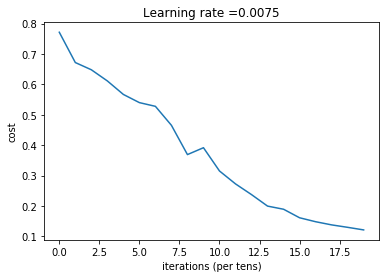

In [ ]:
# 设置好深度神经网络的层次信息——下面代表了一个4层的神经网络（12288是输入层），
# 第一层有20个神经元，第二层有7个神经元。。。
# 你也可以构建任意层任意神经元数量的神经网络，只需要更改下面这个数组就可以了
layers_dims = [12288, 20, 7, 5, 1]

# 根据上面的层次信息来构建一个深度神经网络，并且用之前加载的数据集来训练这个神经网络，得出训练后的参数
parameters = dnn_model(train_x, train_y, layers_dims, num_iterations=2000, print_cost=True)

下面我们再编写一个预测函数，来用上面训练得到的参数来进行预测

In [ ]:
def predict(X,parameters):   
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # 进行一次前向传播，得到预测结果
    probas, caches = L_model_forward(X, parameters)
    print(probas)
    # 将预测结果转化成0和1的形式，即大于0.5的就是1，否则就是0
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
        
    return p

In [ ]:
# 对训练数据集进行预测
pred_train = predict(train_x,parameters)
print("预测准确率是: " + str(np.sum((pred_train == train_y) / train_x.shape[1])))

[[0.11355187 0.11321288 0.99421715 0.11320249 0.11151952 0.11320249
  0.11320249 0.99868565 0.11297217 0.11320249 0.11320249 0.99212492
  0.11361743 0.99978505 0.99238936 0.11223783 0.11320249 0.11320249
  0.11273694 0.99979337 0.11320249 0.11113007 0.11321129 0.11336202
  0.99805632 0.99272884 0.11158027 0.99875585 0.11320249 0.98798578
  0.11340662 0.11231844 0.11339752 0.11237601 0.11320249 0.11320488
  0.11320249 0.11305355 0.95459455 0.11634576 0.11320249 0.97668361
  0.99827849 0.11320249 0.11320249 0.11209139 0.11292575 0.98122606
  0.11320249 0.11309981 0.96476361 0.11320249 0.11320249 0.11328443
  0.99710096 0.11320249 0.99809563 0.98289964 0.11320249 0.99937053
  0.99667978 0.98935349 0.11320249 0.11320249 0.11320249 0.11378944
  0.11269344 0.11198864 0.11320249 0.11320249 0.11320249 0.99997463
  0.11320249 0.11229775 0.11320249 0.15924221 0.11320249 0.11320249
  0.11320249 0.11320249 0.11320249 0.11394959 0.11320249 0.99569335
  0.98801701 0.11320249 0.11374373 0.11320249 0.

In [ ]:
# 对测试数据集进行预测
pred_test = predict(test_x,parameters)
print("预测准确率是: "  + str(np.sum((pred_test == test_y) / test_x.shape[1])))

[[0.99857185 0.9958758  0.97549937 0.81043887 0.97941449 0.54017501
  0.78451331 0.99878998 0.98025811 0.98951161 0.9952642  0.4091547
  0.98829682 0.99910113 0.11320249 0.99766381 0.26173268 0.99079338
  0.80657707 0.13828897 0.9813595  0.12434335 0.11320249 0.74828188
  0.95205147 0.98900063 0.94263045 0.11320249 0.21053047 0.99547312
  0.95271361 0.99978218 0.99466482 0.97009512 0.83908259 0.11320249
  0.12638741 0.6924672  0.91541111 0.11320249 0.93824396 0.96909619
  0.82745341 0.11345511 0.95550664 0.99630299 0.55384169 0.99997405
  0.60810654 0.19278617]]
预测准确率是: 0.8


可以看到，比我们之前的的单神经元网络的0.7提升了0.1。不要小看这0.1，这是很难提升的。别说是0.1，如果全世界都只能做到0.9，如果你能提升0.05，那么你就享誉全球啦！

当然，0.8还不是我们的极限，后面的文章我会带领大家继续提升它。